In [151]:
# Standard Imports
import numpy as np
from time import time
from matplotlib import pyplot as plt

# SHAPER
from pyshaper.CommonObservables import buildCommmonObservables
from pyshaper.Observables import Observable
from pyshaper.Shaper import Shaper

# Utils
from pyshaper.utils.data_utils import load_cmsopendata
from pyshaper.utils.plot_utils import plot_event


# Necessary GPU nonsense
import torch 

if torch.cuda.is_available():  
    dev = "cuda:0" 
    print("Using GPU!")
else:  
    dev = "cpu"  
    print("Using CPU!")
device = torch.device(dev) 

Using CPU!


Max # of particles: 76
test


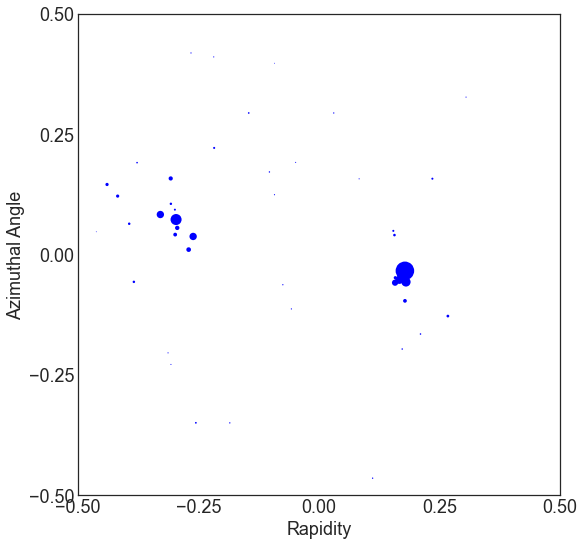

<AxesSubplot:xlabel='Rapidity', ylabel='Azimuthal Angle'>

In [152]:
# Parameters
R = 0.5
beta = 1.0
N = 50
pt_lower = 475
pt_upper = 525
eta = 1.9
quality = 2
pad = 125
plot_dir = "results"

# Load data (NOTE: Need the `energyflow` package installed for the default dataset, or provide your own data)
dataset, sim_weights, sim_factors = load_cmsopendata("~/.energyflow/", "sim", pt_lower, pt_upper, eta, quality, pad, n = N)


example_event = dataset[0]
plot_event(example_event[0], example_event[1], R, color = "blue")

# Spectral Representation

Given an event $\mathcal{E}$ with energy flow (density) $\mathcal(E)(x) = \sum_i E_i \delta(x-x_i)$, the spectral representation (density) $s(\omega)$ is $s(\omega) = \sum_{ij} E_i E_j \delta(\omega - \omega(x_i, x_j))$, where $\omega(x_i, x_j) \equiv \omega_{ij} = 1-\cos(\theta_{ij})$

In code, an event with $N$ particles will be represented in spectral representation by an $[1+{N \choose 2}] \times 2$ array, where the first column is a sorted list of pairwise distances $\omega_{ij}$ and the second is the associated pairwise energy $2E_i E_j$. The 0th element is $\omega_{ij} = 0$ with energy $\sum E_i^2$.  

TODO: numpy padding / jagged arrays

/var/folders/w0/0wlcf9nd71s7r2340_yg6njm0000gq/T/ipykernel_9667/1462185284.py:55: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 0.25)
/var/folders/w0/0wlcf9nd71s7r2340_yg6njm0000gq/T/ipykernel_9667/1462185284.py:69: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 0.25)


(7.975556496383302e-08, 0.25)

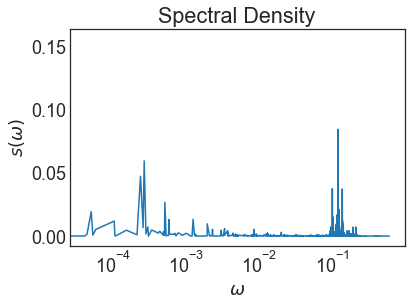

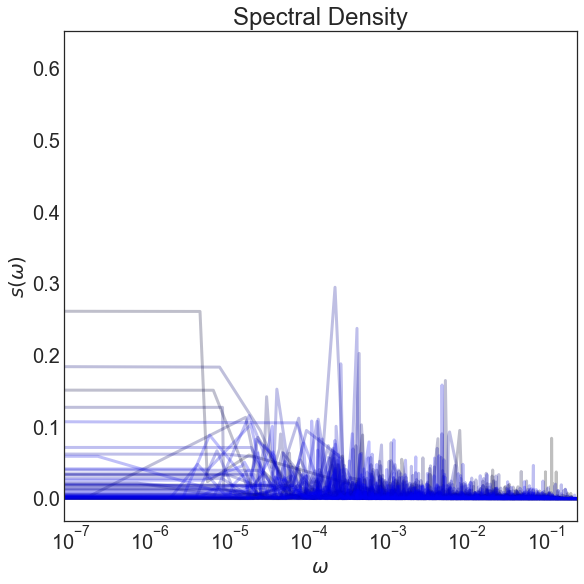

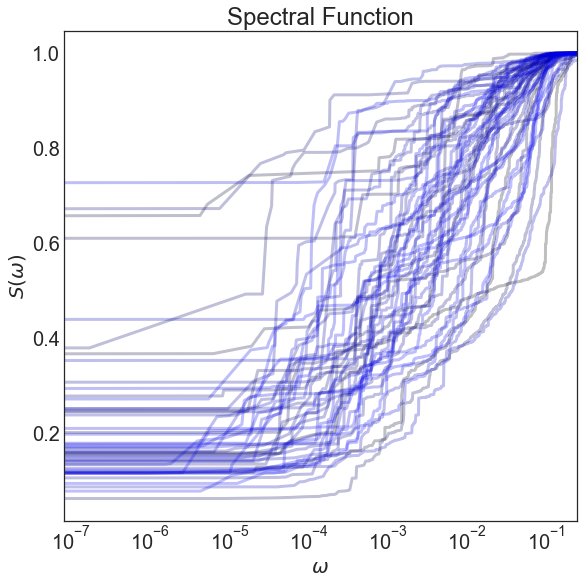

In [153]:
# TODO: my SHAPER representation of events is somewhat inefficient. do over.
def compute_spectral_representation(event, pad = 125, omega_max = 2, type = "event"):

    points, zs = event[0], event[1]
    euclidean_distance_squared = np.sum(np.square(points[:, None, :] - points[None, :, :]), axis=-1)
    
    # Upper Triangle Matrices
    if type == "event":
        omega_ij = np.triu(euclidean_distance_squared / 2)
    elif type == "jet":
        omega_ij = np.triu(np.sqrt(euclidean_distance_squared ))
    ee_ij = np.triu(zs[:,None] * zs[None,:])
    ee2 = np.trace(ee_ij)

    # Flatten to 1D Spectral Representation and remove 0s
    omega_n = omega_ij.flatten()
    ee_n = 2 * ee_ij.flatten()
    mask = omega_n > 0
    
    omega_n = omega_n[mask]
    ee_n = ee_n[mask]
    s = np.stack((omega_n, ee_n)).T
    
    # Sort and append 0
    s = s[s[:,0].argsort()]
    s0 = np.array(((0, ee2,),))
    s = np.concatenate((s0, s), axis = 0)

    return s

def cumulative_spectral_function(s):
    S = s.copy()
    S[:,1] = np.cumsum(S[:,1])
    return S


s = compute_spectral_representation(example_event)
plt.plot(s[:,0], s[:,1])
plt.xscale("log")
plt.title("Spectral Density")
plt.ylabel("$s(\omega)$")
plt.xlabel("$\omega$")


# Weird plot
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
for (i,event) in enumerate(dataset):
    s = compute_spectral_representation(event)
    plt.plot(s[:,0], s[:,1], color = (0,0,np.sqrt(i/len(dataset))), alpha = 0.25, lw = 3)
plt.xscale("log")
plt.title("Spectral Density")
plt.ylabel("$s(\omega)$")
plt.xlabel("$\omega$")
plt.xlim(0, 0.25)


# Weird plot
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))
for (i,event) in enumerate(dataset):
    s = compute_spectral_representation(event)
    S = cumulative_spectral_function(s)
    plt.plot(S[:,0], S[:,1], color = (0,0,np.sqrt(i/len(dataset))), alpha = 0.25, lw = 3)
plt.xscale("log")
plt.title("Spectral Function")
plt.ylabel("$S(\omega)$")
plt.xlabel("$\omega$")
plt.xlim(0, 0.25)


    

# $p = 2$ Spectral Metric

In [154]:
def weighted_sum(s, p = 2, max_index = None, inclusive = True):

    if max_index is None:
        return np.sum(s[:,1] * np.power(s[:,0], 2))
    else:
        max_index = max_index + 1 if inclusive else max_index
        return np.sum(s[:max_index,1] * np.power(s[:max_index,0], 2))


def energy_sum(s, max_index = None, inclusive = True):
    if max_index is None:
        return np.sum(s[:,1])
    else:
        max_index = max_index + 1 if inclusive else max_index
        return np.sum(s[:max_index,1] )


def cross_term(s1, s2):

    # Cross term
    omega1s = s1[:,0]
    omega2s = s2[:,0]

    E1s = s1[:,1]
    E2s = s2[:,1]

    E1_cumsums = np.cumsum(E1s)
    E2_cumsums = np.cumsum(E2s)
    shifted_E1_cumsums = np.concatenate((np.array((E1_cumsums[0],)), E1_cumsums[:-1])) 
    shifted_E2_cumsums = np.concatenate((np.array((E2_cumsums[0],)), E2_cumsums[:-1])) 

    omega_n_omega_l = omega1s[:,None] * omega2s[None,:]
    minE = np.minimum(E1_cumsums[:,None], E2_cumsums[None,:])
    maxE = np.maximum(shifted_E1_cumsums[:,None], shifted_E2_cumsums[None,:])
    x = minE - maxE

    cross_term = np.sum(omega_n_omega_l * x * theta(x))
    return cross_term

def theta(x):

    return x > 0 


def ds2(s1, s2):

    term1 = weighted_sum(s1)
    term2 = weighted_sum(s2)

    return term1 + term2 - 2*cross_term(s1, s2)





In [155]:
# SANITY CHECKS
from tqdm import tqdm

s = compute_spectral_representation(example_event)
EMDs = []
for e1 in tqdm(dataset):
    for e2 in dataset:

        s1 = compute_spectral_representation(e1)
        s2 = compute_spectral_representation(e2)
        EMDs.append(ds2(s1, s2))
EMDs = np.array(EMDs)




100%|██████████| 50/50 [01:39<00:00,  1.99s/it]


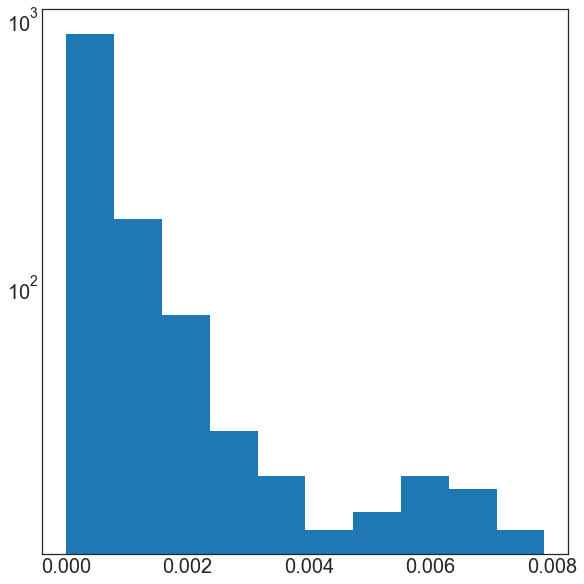

In [156]:
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  
plt.hist(EMDs[EMDs > 1e-15], density = True)
plt.yscale('log')

# 2-sPronginess

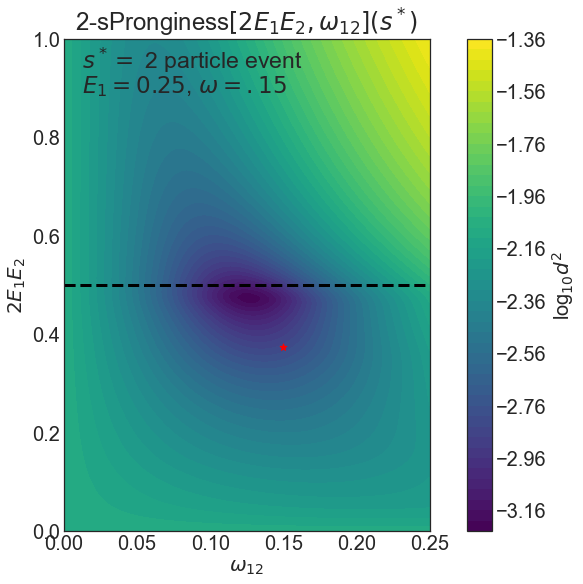

In [157]:
# 2-sPronginess
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  


es = np.linspace(0,1, 100)
omegas = np.linspace(0,.25, 100)
Es, Omegas = np.meshgrid(es, omegas)
EMDs = np.zeros_like(Es)

for (i, e) in enumerate(es):
    for (j, omega) in enumerate(omegas):

        e1 = 0.25
        omega1 = 0.15
        s1 =  np.array((   (0, 1 - 2*(e1*(1-e1))), (omega1, 2 * e1 * (1-e1)),     )) 
        
        s2 = np.array((   (0, 1 - e), (omega, e),     ))
        d = ds2(s, s2)
        EMDs[j,i] = d


 # Weird plot
     
plt.contourf(Omegas, Es, np.log10(EMDs), levels = 50, cmap = "viridis")
cbar = plt.colorbar()
plt.title("2-sPronginess$[2E_1E_2, \omega_{12}](s^*)$")
plt.ylabel("$2E_1 E_2$")
plt.xlabel("$\omega_{12}$")
plt.text(0.05, 0.99 - 0.05*1, r"$s^*=$ 2 particle event", fontsize = 23, transform = plt.gca().transAxes)
plt.text(0.05, 0.99 - 0.05*2, r"$E_1 = 0.25$, $\omega = .15$", fontsize = 23, transform = plt.gca().transAxes)
plt.axhline(0.5, color = "black", lw = 3, ls = "--")
plt.scatter(omega1,2*e1*(1-e1), s = 50, color = "red", marker = "*")

cbar.set_label("log$_{10}d^2$")


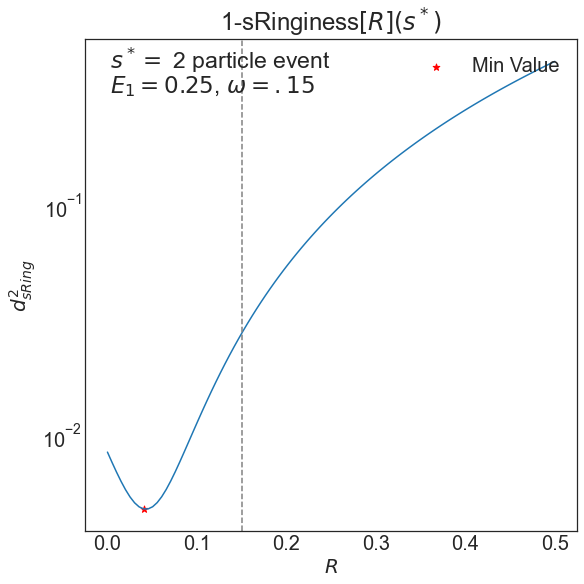

In [158]:
# sRinginess

def ds2_ring(s, R, E_tot = 1):

    term1 = weighted_sum(s)
    term2 = 2*E_tot**2 * R**2


    # Cross term
    omega1s = s[:,0]
    E1s = s[:,1]

    # Reverse cumsums
    E1_cumsums = np.cumsum(E1s)
    shifted_E1_cumsums = np.concatenate((np.array((E1_cumsums[0],)), E1_cumsums[:-1])) 
    total_E = np.sum(E1s[1:])
    E1_reverse_cumsums = total_E - shifted_E1_cumsums #notice reversed
    shifted_E1_reverse_cumsums = total_E - E1_cumsums #notice reversed

    #
    x = np.sin(np.pi / 2 / E_tot**2 * E1_reverse_cumsums) - np.sin(np.pi / 2 / E_tot**2 * shifted_E1_reverse_cumsums)


    cross_term = np.sum(omega1s * x)

    

    return term1 + term2 -8*R/np.pi *cross_term


Rs = np.linspace(0,.5,100)
EMDs = []
for R in Rs:

    e1 = 0.25
    omega1 = 0.15
    s1 =  np.array((   (0, 1 - 2*(e1*(1-e1))), (omega1, 2 * e1 * (1-e1)),     )) 

    d = ds2_ring(s1, R)
    EMDs.append(d)

EMDs = np.array(EMDs)

# 2-sPronginess
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  
plt.plot(Rs, EMDs)
plt.title("1-sRinginess$[R](s^*)$")
plt.ylabel("$d^2_{sRing}$")
plt.xlabel("$R$")
plt.text(0.05, 0.99 - 0.05*1, r"$s^*=$ 2 particle event", fontsize = 23, transform = plt.gca().transAxes)
plt.text(0.05, 0.99 - 0.05*2, r"$E_1 = 0.25$, $\omega = .15$", fontsize = 23, transform = plt.gca().transAxes)

min_value = Rs[np.argmin(EMDs)]
plt.scatter(min_value,EMDs[np.argmin(EMDs)], s = 50, color = "red", marker = "*", label = "Min Value")
plt.yscale("log")
plt.axvline(0.15, color = "grey", ls = "--")
plt.legend(loc = "upper right", frameon = False)
    

0.15286528652865286


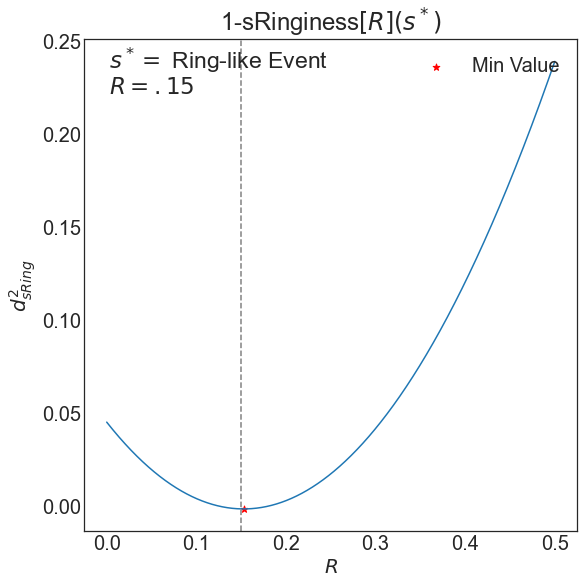

In [162]:
Rs = np.linspace(0,.5,500)
EMDs = []
for R in Rs:

    r = .15
    n = 50
    thetas = np.linspace(0, 2*np.pi, n)
    zs = []
    positions = []
    for t in thetas:
        positions.append((r * np.cos(t), r * np.sin(t)))
        zs.append(1.0 / n)
    event = (np.array(positions), np.array(zs))

    s1 = compute_spectral_representation(event, type = "jet")                    
    
    d = ds2_ring(s1, R)
    EMDs.append(d)

EMDs = np.array(EMDs)

# 2-sPronginess
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(constrained_layout=True, figsize=(8, 8))  
plt.plot(Rs, EMDs)
plt.title("1-sRinginess$[R](s^*)$")
plt.ylabel("$d^2_{sRing}$")
plt.xlabel("$R$")
plt.text(0.05, 0.99 - 0.05*1, r"$s^*=$ Ring-like Event", fontsize = 23, transform = plt.gca().transAxes)
plt.text(0.05, 0.99 - 0.05*2, r"$R = .15$", fontsize = 23, transform = plt.gca().transAxes)

min_value = Rs[np.argmin(EMDs)]
plt.scatter(min_value,EMDs[np.argmin(EMDs)], s = 50, color = "red", marker = "*", label = "Min Value")
# plt.yscale("log")
plt.axvline(0.15, color = "grey", ls = "--")
plt.legend(loc = "upper right", frameon = False)
print(min_value)

# General Spectral Metric